<b>Arnie Larson<br/>
Acoustics Homework Notes<br/>
1/19/2023<br/>
</b>


#### HW 2

- 5 problems
- Solution to wave equation in spherical coordinates
- Computations of RMS quantities
- Power Spectral Densities (Fourier Transforms)
- Decidecades, integrating over bands
- Relationships between Pressure, and RMS particle coordinates

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# See documentation here: https://docs.scipy.org/doc/scipy/tutorial/fft.html
from scipy.fft import fft, fftfreq
import scipy.io as io
import os

### Problem 1 

Solutions to the wave equation, in 3 dimensions, with point source, **see attached notes**.

1.)  Solution $P(r,t) = \frac{A}{r}e^{j(kz - \omega t}$ is a solution to the wave equation in spherical coordinates provided $c = \omega/k$

2.) At $10m,  P_{RMS} = 1 Pa \rightarrow A = 10 \sqrt{2} \thinspace [Pa \thinspace m]$   

3.) Plot SPL from 1M to 100M.  $SPL = 10 log_{10}(P^2/P_{ref}^2)$  (See below)

4.) Plot the rms velocity.  $v_{RMS} = \frac{P_{RMS}}{c \rho_0}$

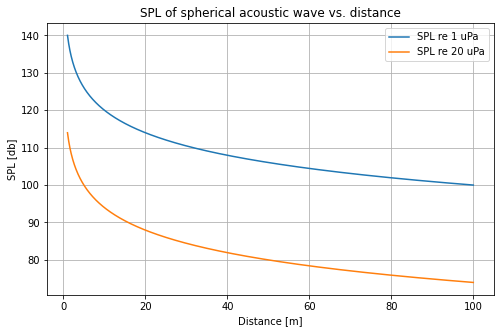

In [2]:
# Plot of SPL vs distance
x=np.linspace(1,100,1000)
# RMS at 10m is 1 Pa, 
P2=(10/x)**2
SPL=10*np.log10(P2/(1e-6)**2)
SPLre20=10*np.log10(P2/(20e-6)**2)
fig, ax = plt.subplots(figsize=(8,5));
ax.plot(x, SPL,label='SPL re 1 uPa')
ax.plot(x,SPLre20,label='SPL re 20 uPa')
ax.grid('true'); ax.legend()
ax.set_xlabel("Distance [m]"), ax.set_ylabel("SPL [db]")
ax.set_title("SPL of spherical acoustic wave vs. distance")
plt.show()

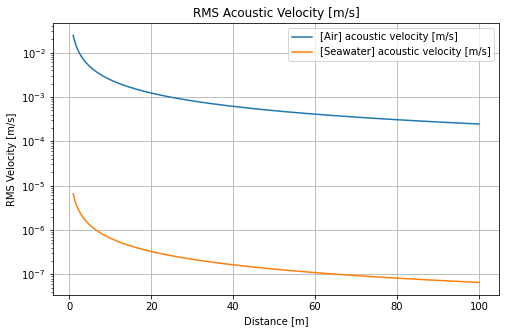

In [30]:
# plot the rms particle velocity, (v_rms = p_rms / rho_o * c) in radial direction
# Air, rho_0 = 1.2, c = 340 m/s
v1=(10/x/1.2/340)
# Water, rho_0 = 1027, c = 1490 m/s
v2=(10/x/1027/1490)
fig, ax = plt.subplots(figsize=(8,5));
ax.plot(x, v1, label='[Air] acoustic velocity [m/s]')
ax.plot(x, v2,label='[Seawater] acoustic velocity [m/s]')
ax.set_yscale("log"); ax.grid('true'); ax.legend()
ax.set_xlabel("Distance [m]"), ax.set_ylabel("RMS Velocity [m/s]")
ax.set_title("RMS Acoustic Velocity [m/s]")
plt.show()

### Problem 2

- Calculate RMS values, (see notes), (time average of the integral of the signal squared)

- Calculated analytically $\sqrt{\frac{1}{T}\int cos^2(\omega t) dt}$

- Numerically with a cosine signal, sampled at 500 Hz

- Both calculations give an answer $\approx \frac{1}{\sqrt{2}}$

- Compute the RMS pressure for a real data set (WaveForm_Problem2_Part2.csv) ($= 0.032 \thinspace Pa$)

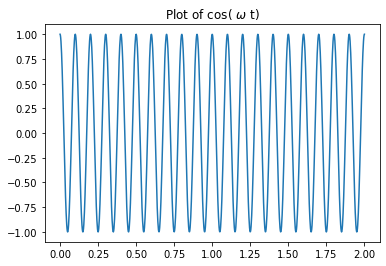

In [111]:
# Sample a cos at 500 Hz (fs=500 Hz)
# Lets go ahead and simulate in time domain for 1 second
t_max = 2;  fs = 500; f = 10;
t=np.linspace(0,t_max,num=t_max*fs)
s=np.cos(2*np.pi*f*t)
plt.plot(t, s); plt.title("Plot of cos( $\omega$ t)"); plt.show()

In [112]:
# calculate RMS value...  sqrt(integral of y(t)^2 over 1 period (or arbitrary time really))
# easy way (1/T)*sum(s.*s)*dt
integral=(1/t_max)*np.sum(s*s)*(1/fs)
rms_val=np.sqrt(integral)
print("RMS (easiest way): {:.3f} (1/sqrt(2) = {:.3f})".format(rms_val, 1/np.sqrt(2)))

RMS (easiest way): 0.707 (1/sqrt(2) = 0.707)


In [113]:
# load csv data into np arrays; note numpy has a getfromtxt() function that should probably be used
def load(fname):
    data_dir="data/ME525/data2/"
    file_path=os.path.join(os.getcwd(),data_dir,fname)
    
    t=[]; p=[]
    first=True
    for line in open(file_path).readlines():
        if first:
            print("{}, First Line: {}".format(fname, line.strip()))
            first=False
        else:
            try:
                d=line.split(",")
                t.append(np.float32(d[0].strip()))
                p.append(np.float32(d[1].strip()))
            except:
                print("Error processing: {}".format(line))
                
    return np.array(t, dtype=np.float32), np.array(p, dtype=np.float32)

# calculate the rms value (the easy way)
# 
def get_rms(p,t):
    ## check pressure mean value
    print("Pressure mean: {:.5f}".format(p.mean()))
    N=t.shape[0]
    T=t[-1] - t[0] ## total signal time
    dt = T/N       ## delta T, time interval
    print("Signal Time: {:.3f} [s]".format(T))
    print("DT, Time interval: {:.3f} [s]".format(dt))
    rms = np.sqrt( (1/T)*(np.sum(p*p)*dt) )
    print("RMS value: {:.3f} [Pa]".format(rms))

In [114]:
t, p = load('WaveForm_Problem2_Part2.csv')
print("shape of t: {}".format(t.shape))
print("shape of p: {}".format(p.shape))

WaveForm_Problem2_Part2.csv, First Line: Time [s],Pressure [Pa]
shape of t: (2000,)
shape of p: (2000,)


In [115]:
get_rms(p,t)

Pressure mean: 0.00000
Signal Time: 1.999 [s]
DT, Time interval: 0.001 [s]
RMS value: 0.032 [Pa]


### Problem 3

- Load real data sets
- Plot data sets
- Calculate Power Spectral Density
- Verify Parsevals theorem

Note, I plot the timeseries data, the FFT, and the PSD for each source.

Note to self:  I calculate only the positive frequencies (So frequencies and FFT are modified initially).

Notes on the sounds.  The ambient noise seems to have basically just a pink noise profile.  Both the Bottle and Whistle are narrow band sources with what seems to be a ambient background that mimicks the ambient noise.  Parsevals theorem as stated in lecture notes is verified with the data at the end.

Notes to self on the FFT, for a time series $x(t)$ sampled $N$ times on $(0,T)$ defines discrete series $x[n]$ where $n \in (0,N/f_S)$ with $f_S = N/T$

The DFFT is symmetric, and we only utilize the positive frequencies (up to $f_s/2$) and require a factor of 2 to keep "all of the energy" in the signal.  After we interpret the N data points as points in time $t \in (0, T)$ the units of FFT should be \[Data Units]/[Hz]

FFT $\rightarrow  X[k] = \sum_{n=0}^{N-1}x[n]e^{(\frac{-j 2 \pi}{N} n k)}$

IFFT $\rightarrow x[n] = \frac{1}{N} \sum_{k=0}^{N-1}X[k]e^{(\frac{j 2 \pi}{N} n k)}$

Parseval's Theorem

$\sum_{n=0}^{N-1} x[n]^2 = \frac{1}{N} \sum_{k=0}^{N-1} X[k]^2  \rightarrow \int x(t)^2dt = \int X(f)^2 df$

When I validate this with the DFT this leads me to the normalization that $X[k] = \frac{1}{N}\sum_n^{N}x[n]e^{-j 2 \pi n k / N}$


In [6]:
# Ambient 1
t1,p1 = load("Ambient-1.csv")
# Bottle
t2,p2 = load("Bottle.csv")
# Whistle
t3,p3 = load("Whistle-1.csv")
print("Mean ambient: {:.4f}".format(p1.mean()))
print("Mean bottle: {:.4f}".format(p2.mean()))
print("Mean whistle: {:.4f}".format(p3.mean()))

Ambient-1.csv, First Line: T [s],p [Pa]
Bottle.csv, First Line: t [s],p [Pa]
Whistle-1.csv, First Line: Time [s],P [Pa]
Mean ambient: -0.0000
Mean bottle: 0.0000
Mean whistle: 0.0000


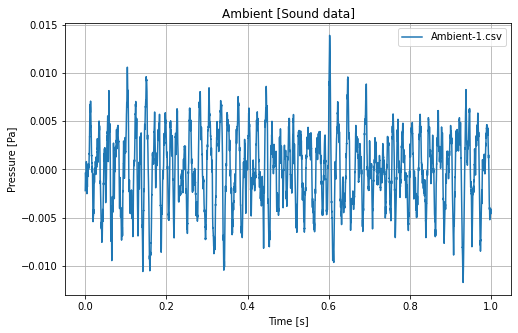

In [7]:
fig, ax = plt.subplots(figsize=(8,5));
ax.plot(t1, p1, label='Ambient-1.csv')
ax.grid('true'); ax.legend()
ax.set_xlabel("Time [s]"), ax.set_ylabel("Pressure [Pa]")
ax.set_title("Ambient [Sound data]")
plt.show()

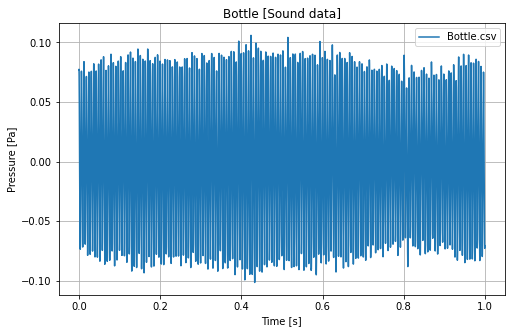

In [8]:
fig, ax = plt.subplots(figsize=(8,5));
ax.plot(t2, p2, label='Bottle.csv')
ax.grid('true'); ax.legend()
ax.set_xlabel("Time [s]"), ax.set_ylabel("Pressure [Pa]")
ax.set_title("Bottle [Sound data]")
plt.show()

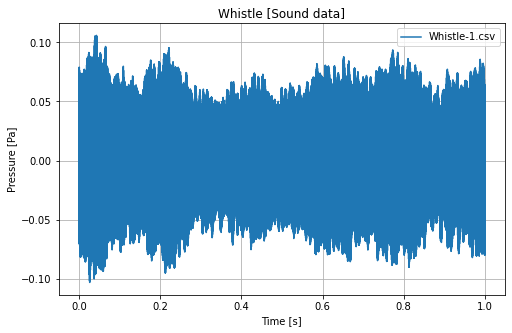

In [9]:
fig, ax = plt.subplots(figsize=(8,5));
ax.plot(t3, p3, label='Whistle-1.csv')
ax.grid('true'); ax.legend()
ax.set_xlabel("Time [s]"), ax.set_ylabel("Pressure [Pa]")
ax.set_title("Whistle [Sound data]")
plt.show()

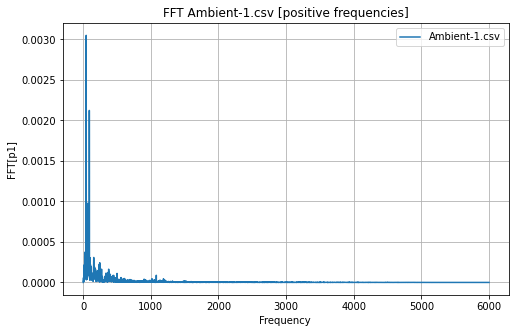

In [117]:
## Cacluate PSD, FFT (Signal is real, so )

N1=p1.shape[0]; DT = t1[1] - t1[0];  # time delta between points
F1=np.abs(fft(p1))/N1                # normalized fourier spectrum [Pa / Hz]  (with all frequencies)
f1=fftfreq(N1, DT)[:N1//2]           # positive frequencies
## Plot the FFT
fig, ax = plt.subplots(figsize=(8,5));
ax.plot(f1, 2*F1[:N1//2], label='Ambient-1.csv')
ax.grid('true'); ax.legend()
ax.set_xlabel("Frequency "), ax.set_ylabel("FFT[p1]")
ax.set_title("FFT Ambient-1.csv [positive frequencies]")
plt.show()


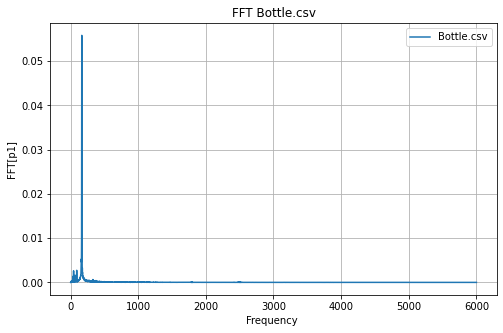

In [134]:
##  FFT of Bottle
N2=t2.shape[0]; DT2 = t2[1] - t2[0]
F2=np.abs(fft(p2))/N2         # fourier spectrum, 
f2=fftfreq(N2, DT2)[:N2//2]   # positive frequencies
## Plot the FFT
fig, ax = plt.subplots(figsize=(8,5));
ax.plot(f2, 2*F2[:N2//2], label='Bottle.csv')
ax.grid('true'); ax.legend()
ax.set_xlabel("Frequency "), ax.set_ylabel("FFT[p1]")
ax.set_title("FFT Bottle.csv")
plt.show()

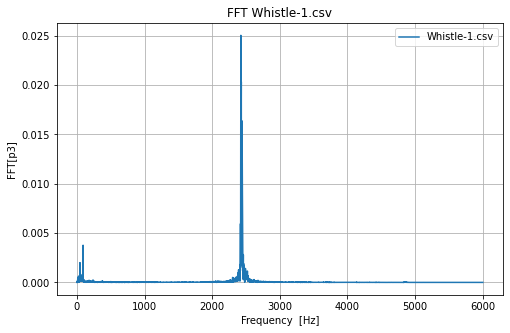

In [135]:
##  FFT of Whistle
N3=t3.shape[0]; DT3 = t3[1] - t3[0]
F3=np.abs(fft(p3))/N3               # fourier spectrum
f3=fftfreq(N3, DT3)[:N3//2]         # the postivie frequences
## Plot the FFT
fig, ax = plt.subplots(figsize=(8,5));
ax.plot(f3, 2*F3[:N3//2], label='Whistle-1.csv')
ax.grid('true'); ax.legend()
ax.set_xlabel("Frequency  [Hz]"), ax.set_ylabel("FFT[p3]")
ax.set_title("FFT Whistle-1.csv")
plt.show()

sum of signal: 0.179; sum of PSD: 0.000


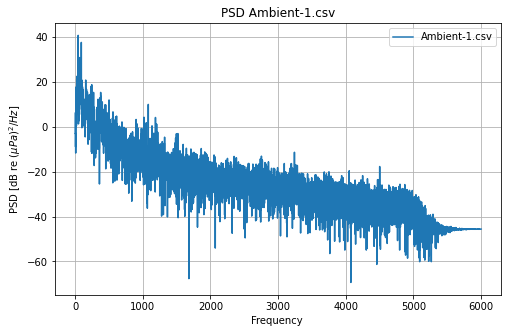

In [136]:
# PSD of Ambient (2*(FFT(2:N/2+1)).^2)/N^2
# Note I'm dropping the "DC" part, since that has presumably been removed in pre processing
PSD1=2*F1[1:N1//2]*F1[1:N1//2]
PSD1_db = 10*np.log10(PSD1/(20e-6)**2)
fig, ax = plt.subplots(figsize=(8,5));
ax.plot(f1[1:], PSD1_db, label='Ambient-1.csv')
ax.grid('true'); ax.legend()
ax.set_xlabel("Frequency "), ax.set_ylabel("PSD [dB re $(\mu Pa)^2/Hz$]")
ax.set_title("PSD Ambient-1.csv")
print("sum of signal: {:.3f}; sum of PSD: {:.3f}".format(np.sum(p1*p1), np.sum(PSD1)))
plt.show()


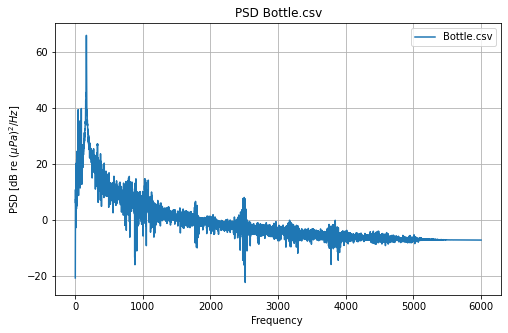

In [137]:
# PSD of Bottle (2*(FFT(2:N/2+1)).^2)
# Note I'm dropping the "DC" part, since that has presumably been removed in pre processing
PSD2=2*F2[1:N2//2]*F2[1:N2//2]
PSD2_db = 10*np.log10(PSD2/(20e-6)**2)

fig, ax = plt.subplots(figsize=(8,5));
ax.plot(f2[1:], PSD2_db, label='Bottle.csv')
ax.grid('true'); ax.legend()
ax.set_xlabel("Frequency "), ax.set_ylabel("PSD [dB re $(\mu Pa)^2/Hz$]")
ax.set_title("PSD Bottle.csv")
plt.show()


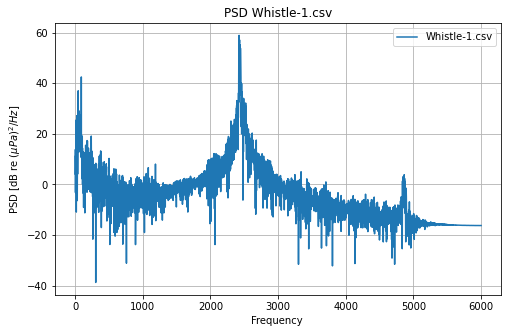

In [142]:
# PSD of Whistle (2*(FFT(2:N/2+1)).^2)
# Note I'm dropping the "DC" part, since that has presumably been removed in pre processing
PSD3=2*F3[1:N3//2]*F3[1:N3//2]
PSD3_db = 10*np.log10(PSD3/(20e-6)**2)
fig, ax = plt.subplots(figsize=(8,5));
ax.plot(f3[1:], PSD3_db, label='Whistle-1.csv')
ax.grid('true'); ax.legend()
ax.set_xlabel("Frequency "), ax.set_ylabel("PSD [dB re $(\mu Pa)^2/Hz$]")
ax.set_title("PSD Whistle-1.csv")
plt.show()

In [145]:
# Check Parsevals Theorem = the energy of the signal can be computed in time or frequency domain identically
#
# p1 = Signal from Ambient-1.csv (Pa)
# F1 = (1/N)* abs(FFT(p1))
# integral ~ SUM(p*p)*dT = SUM(2*F*F)*dF (over positive frequencies)
#
E1=np.sum(p1*p1)*DT; print("[Ambient-1.csv], Energy in time: {:.6f}".format(E1))
E1f=np.sum(PSD1)*1; print("[Ambient-1.csv], Energy in frequency: {:.6f}".format(E1f))
E2=np.sum(p2*p2)*DT2; print("[Bottle.csv], Energy in time: {:.4f}".format(E2))
E2f=np.sum(PSD2)*1; print("[Bottle.csv], Energy in frequency: {:.4f}".format(E2f))
E2=np.sum(p3*p3)*DT; print("[Whistle-1.csv], Energy in time: {:.4f}".format(E2))
E2f=np.sum(PSD3)*1; print("[Whistle-1.csv], Energy in frequency: {:.4f}".format(E2f))


[Ambient-1.csv], Energy in time: 0.000015
[Ambient-1.csv], Energy in frequency: 0.000015
[Bottle.csv], Energy in time: 0.0034
[Bottle.csv], Energy in frequency: 0.0034
[Whistle-1.csv], Energy in time: 0.0024
[Whistle-1.csv], Energy in frequency: 0.0024


### Problem 4


Investigating decidecade bands, look again at bottle.csv data.

Check Pareval relation to get normalization correct:  $\sum x_n^2 \Delta T = \sum X_k^2 \Delta F$

$T = 1s$,  $\Delta F = \frac{1}{T} = 1 Hz$

$N= 12000 \rightarrow f_s = T/N = 12000 Hz$ and therefore max frequency $f_max = \frac{f_s}{2}$

- Calculating the 1/3 octave bands, $(f_{min}, f_c, f_{max})$ for $n \in (-10,5)$
- Integrate power spectral density over the bands.  (Plot is for 16 bands, with a notible peak)

Most of the power is found in a single band $f_c = 158.49 Hz$, $(69.25 dB)$, validating commentary that this is a narrow band signal.

This energy also dominates the total SPL accross all bands, total SPL found to be $69.3 dB$ re $(20\mu Pa)^2/Hz$

In [5]:
# generate [n,fmin, fx, fmax] tuples, effectively in a 16 x 4 
dd = []

for n in range(-14,6):
    fc=1000*10**(n/10)
    fmin=fc*10**(-1/20)
    fmax=fc*10**(1/20)
    dd.append((n,fc,fmin,fmax))
    print("band {}, fc: {:.3f},  fmin: {:.2f} ({}) [Hz], fmax:  {:.2f} ({}) [Hz]".format(
        n,fc,fmin,np.round(fmin),fmax,np.round(fmax)))

band -14, fc: 39.811,  fmin: 35.48 (35.0) [Hz], fmax:  44.67 (45.0) [Hz]
band -13, fc: 50.119,  fmin: 44.67 (45.0) [Hz], fmax:  56.23 (56.0) [Hz]
band -12, fc: 63.096,  fmin: 56.23 (56.0) [Hz], fmax:  70.79 (71.0) [Hz]
band -11, fc: 79.433,  fmin: 70.79 (71.0) [Hz], fmax:  89.13 (89.0) [Hz]
band -10, fc: 100.000,  fmin: 89.13 (89.0) [Hz], fmax:  112.20 (112.0) [Hz]
band -9, fc: 125.893,  fmin: 112.20 (112.0) [Hz], fmax:  141.25 (141.0) [Hz]
band -8, fc: 158.489,  fmin: 141.25 (141.0) [Hz], fmax:  177.83 (178.0) [Hz]
band -7, fc: 199.526,  fmin: 177.83 (178.0) [Hz], fmax:  223.87 (224.0) [Hz]
band -6, fc: 251.189,  fmin: 223.87 (224.0) [Hz], fmax:  281.84 (282.0) [Hz]
band -5, fc: 316.228,  fmin: 281.84 (282.0) [Hz], fmax:  354.81 (355.0) [Hz]
band -4, fc: 398.107,  fmin: 354.81 (355.0) [Hz], fmax:  446.68 (447.0) [Hz]
band -3, fc: 501.187,  fmin: 446.68 (447.0) [Hz], fmax:  562.34 (562.0) [Hz]
band -2, fc: 630.957,  fmin: 562.34 (562.0) [Hz], fmax:  707.95 (708.0) [Hz]
band -1, fc: 794

In [146]:
## Now integrate pressure squared accross the pressure bands and plot

##  FFT of bottle, again
## Data = p2, t2, 1 second of bottle data, at 12kHz sampling
## Units = [s], [Pa]
N4=t2.shape[0]; DT4 = t2[1] - t2[0]
print("Number of points: {}".format(N4))
F4=fft(p2)            # raw fourier spectrum, (absolute value)
f4=fftfreq(N4, DT4)   # frequencies
DF4=f4[1]-f4[0]       # dF, frequency interval, 1/T = 1Hz
print("dT = {:.4f} [s]; dF = {:.1f} [Hz]".format(DT4,DF4))

Number of points: 12000
dT = 0.0001 [s]; dF = 1.0 [Hz]


In [81]:
## PSD - look at X(k)*X(k), But just the second half (positive frequencies), normalized by 1/N
## In Python/Scipy - the FFT and FFTFreq functions yield 0:N/2 (exclusive on end point) are the positive frequencies
## At N/2 the left edge of the negative frequencies begins
PSD4 = 2*np.abs(F4[:N4//2])*np.abs(F4[:N4//2])/(N4**2)
PSD4_log = 10*np.log10(PSD4/(20*1e-6)**2)
sumx2 = np.sum(p2*p2)*DT4
sumX2 = np.sum(PSD4)*DF4
print("Checking energy of signal: sum(x(t)*x(t)) {:.5f}; sum(x(k)*x(k)/N) {:.5f}".format(sumx2,sumX2))

print("Max energy is found at freq: {} Hz with energy {:.4f} dB".format(f4[np.argmax(PSD4)], PSD4_log.max()))

Checking energy of signal: sum(x(t)*x(t)) 0.00343; sum(x(k)*x(k)/N) 0.00343
Max energy is found at freq: 165.06602387614626 Hz with energy 65.9026 dB


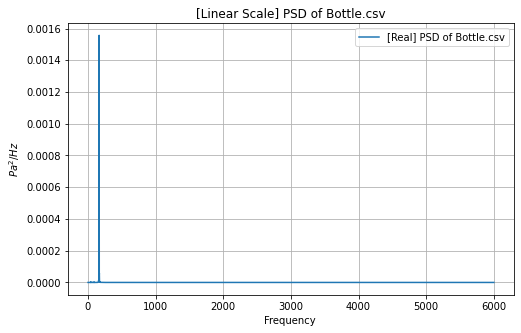

In [67]:
fig, ax = plt.subplots(figsize=(8,5));
ax.plot(f4[1:N4//2], PSD4[1:], label='[Real] PSD of Bottle.csv')
ax.grid('true'); ax.legend(); #ax.set_yscale('log')
ax.set_xlabel("Frequency "), ax.set_ylabel("$Pa^2/Hz$")
ax.set_title("[Linear Scale] PSD of Bottle.csv")
plt.show()

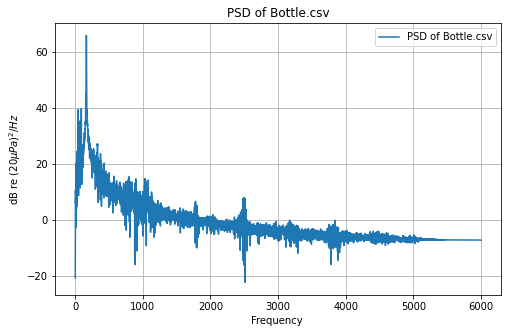

In [150]:
fig, ax = plt.subplots(figsize=(8,5));
ax.plot(f4[1:N4//2], PSD4_log[1:], label='PSD of Bottle.csv')
ax.grid('true'); ax.legend(); #ax.set_yscale('log')
ax.set_xlabel("Frequency "), ax.set_ylabel("dB re $(20 \mu Pa)^2/Hz$")
ax.set_title("PSD of Bottle.csv")
plt.savefig("Bottle_PSD.pdf", format='pdf')
plt.show()

In [84]:
# integration, keep a mapping of band (n,fc) and [data]
# need a function to generate the mapping from the PSD to the integration band
# previously generated structre dd with [(n, fc, fmin, fmax)]
# data is in:  PSD4[1:N4//2] and f4[1:N4//2];   with T = 1s, 
df=1
bands = dict()
minf=np.max(f4); maxf=np.min(f4)
print("Frequencies: ")

for (n, fc, fmin, fmax) in dd:
    bands[fc] = []
c=0
t=0
for idx in range(1,PSD4.shape[0]):
    t+=1
    f=f4[idx]
    for (n, fc, fmin, fmax) in dd:
        if f >= np.round(fmin) and f <= np.round(fmax):
            c+=1
            bands[fc].append(PSD4[idx])
            if f < minf: minf = f                
            if f > maxf: maxf = f
            break
print("Checked {} data points".format(t))
print("Added {} calculations".format(c))
        
# Integrate, map the bands structure to sum the band
integrated = np.reshape(np.zeros(len(dd)*2), (len(dd),2))
integrated_db = np.zeros(integrated[:,1].shape[0])
idx=0
for (n, fc, fmin, fmax) in dd:
    #bandwidth=len(bands[fc])*df # df = 1 Hz
    integrated[idx,:]=[fc, np.sum(bands[fc])*df]
    idx+=1

# Calculate the total SPL
TSPL = 10*np.log10(np.sum(integrated[:,1])/(20e-6)**2)
    
# Convert to dB re (20 uPa)
integrated_db = 10*np.log10(integrated[:,1]/(20e-6)**2)

print("Total SPL: {:.1f}; min freq: {:.2f}, max freq: {:.2f}".format(TSPL, minf, maxf))

TSPL2 = 10*np.log10(PSD4.sum()/(20e-6)**2)
print("Integrated PSD4 as dB: {}".format(TSPL2))


Frequencies: 
Checked 5999 data points
Added 3458 calculations
Total SPL: 69.3; min freq: 89.04, max freq: 3547.42
Integrated PSD4 as dB: 69.33026328783846


In [153]:
integrated   # (frequency f_c, total Pa^2/Hz)

array([[1.00000000e+02, 5.07763177e-06],
       [1.25892541e+02, 6.12308343e-06],
       [1.58489319e+02, 3.37186364e-03],
       [1.99526231e+02, 1.80374062e-05],
       [2.51188643e+02, 3.81990568e-06],
       [3.16227766e+02, 2.81241665e-06],
       [3.98107171e+02, 1.43254307e-06],
       [5.01187234e+02, 7.10639866e-07],
       [6.30957344e+02, 5.56759793e-07],
       [7.94328235e+02, 5.23089645e-07],
       [1.00000000e+03, 4.75484183e-07],
       [1.25892541e+03, 2.36257445e-07],
       [1.58489319e+03, 1.87967894e-07],
       [1.99526231e+03, 1.47046005e-07],
       [2.51188643e+03, 1.49689799e-07],
       [3.16227766e+03, 1.07192800e-07]])

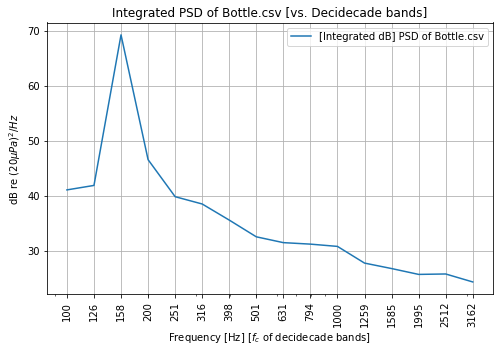

In [148]:

fig, ax = plt.subplots(figsize=(8,5));
ax.plot(integrated[:,0], integrated_db, label='[Integrated dB] PSD of Bottle.csv')
ax.grid('true'); ax.legend(); #ax.set_yscale('log')
# Arg, need to upgrade PIP/Matplotlib to get more control of the ticks

ax.set_xscale('log')
ax.set_xticks(integrated[:,0], labels=[str(int(np.round(x))) for x in integrated[:,0]], rotation='vertical')
#ax.set_xticks(integrated[:,0])
ax.set_xlabel("Frequency [Hz] [$f_c$ of decidecade bands]"), ax.set_ylabel("dB re $(20 \mu Pa)^2/Hz$")
ax.set_title("Integrated PSD of Bottle.csv [vs. Decidecade bands]")
plt.savefig("Integrated_Bottle_PSD.pdf", format='pdf')
plt.show()

### Problem 5


Consider a hypothetical SPL curve that is constant from $1Hz$ to $10kHz$

$P_{rms} = P_{ref}10^{SPL/20}$

$v_{rms} = \frac{P_{rms}}{\rho_0 c_p}$

$\xi_{rms} = \frac{P_{rms}}{\omega \rho_0 c_p}$

$a = \frac{dv}{dt} = - \rho_0 \nabla P \rightarrow a_{rms} = k \rho_0 P_{rms}$


In [25]:
# Constant SPL, say 100 db re (20 uPa)**2
f = np.linspace(1,10000,10000)
SPL = np.full(10000,100)

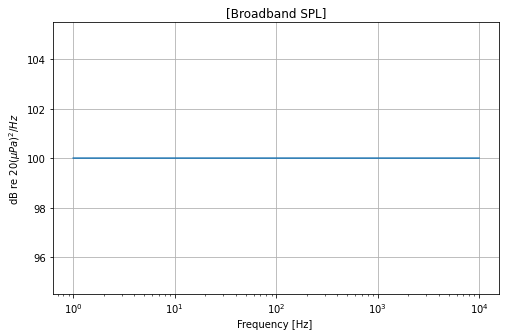

In [27]:
fig, ax = plt.subplots(figsize=(8,5));
ax.plot(f, SPL)
ax.grid('true')
ax.set_xscale('log')
ax.set_xlabel("Frequency [Hz] "), ax.set_ylabel("dB re $20 (\mu Pa)^2/Hz$")
ax.set_title("[Broadband SPL]")
plt.show()

In [36]:
# RMS pressure as funciton of frequency, (in seawater)
Prms = 20e-6 * 10**(SPL/20)
p0=1025; c=1500
# acoustic velocity
vrms = Prms/(p0*c)
# displacement
x = vrms/2/np.pi/f
# acceleration
a = 2*np.pi*p0*Prms*f/c

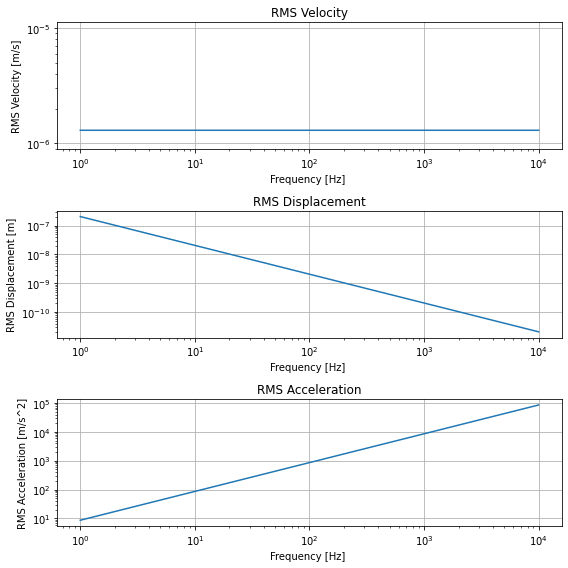

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(8,8));
ax1.plot(f, vrms)
ax1.grid('true')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("Frequency [Hz] "), ax1.set_ylabel("RMS Velocity [m/s]")
ax1.set_title("RMS Velocity")
ax2.plot(f, x)
ax2.grid('true')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("Frequency [Hz] "), ax2.set_ylabel("RMS Displacement [m]")
ax2.set_title("RMS Displacement")
ax3.plot(f, a)
ax3.grid('true')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel("Frequency [Hz] "), ax3.set_ylabel("RMS Acceleration [m/s^2]")
ax3.set_title("RMS Acceleration")
fig.tight_layout()
plt.show()